In [1]:
from common import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from WholeBrain.Utils.p_values import plotComparisonAcrossLabels2
from WholeBrain.Observables.event_based_intrinsic_ignition import EventBasedIntrinsicIgnition
from WholeBrain.Filters.bold_band_pass_filter import BOLDBandPassFilter

************************* Subjects Info *************************
ID              FMRI_TR (ms)    TYPE                           VOLUME (cm³)    # REGIONS WITH TUMOR
sub-CON01       2100.0          none                           0.0             0              
sub-CON02       2100.0          none                           0.0             0              
sub-CON03       2100.0          none                           0.0             0              
sub-CON04       2100.0          none                           0.0             0              
sub-CON05       2400.0          none                           0.0             0              
sub-CON06       2400.0          none                           0.0             0              
sub-CON07       2400.0          none                           0.0             0              
sub-CON08       2400.0          none                           0.0             0              
sub-CON09       2400.0          none                           0.0        

In [2]:
control_subset = subjects.get_control_subset()
tumor_subset = subjects.get_tumor_subset()

In [3]:
preop_ts_dk68 = subjects.filter_preop_ts_dk68()
ignitions = dict()

for sub_id, ts_dk68 in preop_ts_dk68.items():

    tr_ms = subjects.get_subject_by_id(sub_id).get_fmri_tr()

    # If we use length 8 for the 2100ms TR scans and length 7 for the 2400ms scans (or multiple of them), then we have the same windows
    # time frame for each subject (16800ms)
    ignition_tr_length = None
    if np.isclose(tr_ms, 2400.0):
        ignition_tr_length = 7
    elif np.isclose(tr_ms, 2100.0):
        ignition_tr_length = 8
    assert ignition_tr_length is not None, "Ups... TR length not 2100 or 2400..."

    ebig_operator = EventBasedIntrinsicIgnition(ignition_tr_length=ignition_tr_length)

    ebig_dk68 = ebig_operator.from_fMRI(
        ts_dk68,
        # flp=0.01, fhi=0.1
        #   Tagliazucchi, Enzo, Pablo Balenzuela, Daniel Fraiman, and Dante R. Chialvo.
        #       “Criticality in Large-Scale Brain FMRI Dynamics Unveiled by a Novel
        #       Point Process Analysis.” Frontiers in Physiology 3 (2012). https://doi.org/10.3389/fphys.2012.00015.
        #
        # flp=0.04, fhi=0.07. NOTE: This paper uses phased based intrinsic ignition.
        #   Glerean, Enrico, Juha Salmi, Juha M. Lahnakoski, Iiro P. Jääskeläinen, and Mikko Sams.
        #       “Functional Magnetic Resonance Imaging Phase Synchronization as a Measure of Dynamic Functional Connectivity.”
        #       Brain Connectivity 2, no. 2 (April 2012): 91–101. https://doi.org/10.1089/brain.2011.0068.

        # Anira paper flp=0.01 fhi=0.09
        BOLD_filter=BOLDBandPassFilter(tr=tr_ms/1000.0, flp=0.01, fhi=0.09, k=2, remove_strong_artifacts=3.0)
    )
    ignitions[sub_id] = ebig_dk68

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.161e-02 U_stat=8.777e+04


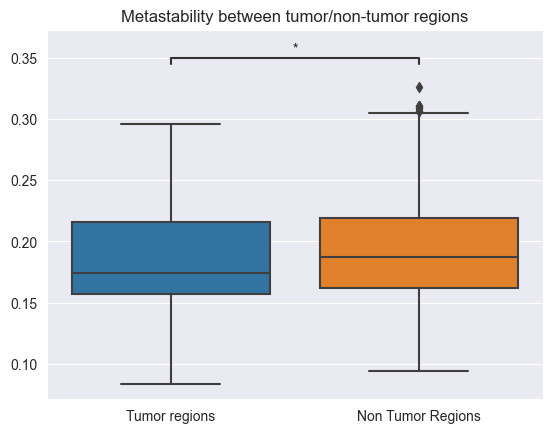

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.161e-02 U_stat=8.777e+04


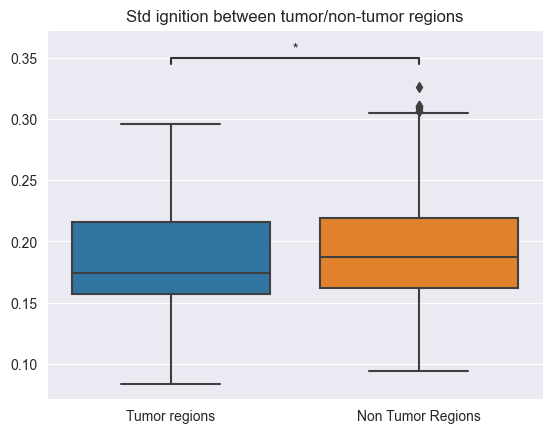

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.161e-02 U_stat=8.777e+04


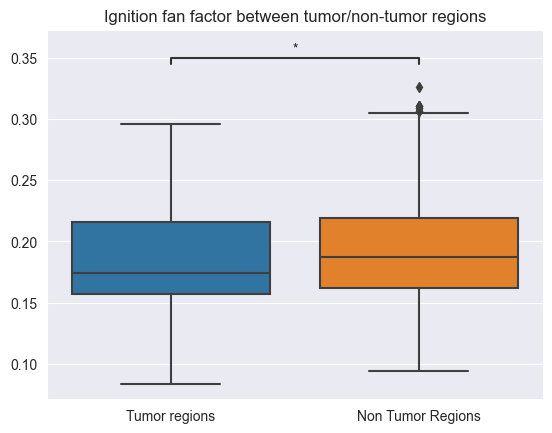

In [7]:
tumor_region_ign_meta = []
non_tumor_region_ign_meta = []
tumor_region_ign_std = []
non_tumor_region_ign_std = []
tumor_region_ign_fanfact = []
non_tumor_region_ign_fanfact = []

for k, s in tumor_subset.items():
    for i in range(68):
        if s.tumor_regions.is_tumor_region_by_id(i):
            tumor_region_ign_meta.append(ignitions[k].mevokedinteg[i])
            tumor_region_ign_std.append(ignitions[k].mevokedinteg[i])
            tumor_region_ign_fanfact.append(ignitions[k].mevokedinteg[i])
        else:
            non_tumor_region_ign_meta.append(ignitions[k].mevokedinteg[i])
            non_tumor_region_ign_std.append(ignitions[k].mevokedinteg[i])
            non_tumor_region_ign_fanfact.append(ignitions[k].mevokedinteg[i])

plotComparisonAcrossLabels2(
    {
        'Tumor regions': tumor_region_ign_meta,
        'Non Tumor Regions': non_tumor_region_ign_meta,
    },
    graphLabel='Metastability between tumor/non-tumor regions'
)

plotComparisonAcrossLabels2(
    {
        'Tumor regions': tumor_region_ign_std,
        'Non Tumor Regions': non_tumor_region_ign_std,
    },
    graphLabel='Std ignition between tumor/non-tumor regions'
)

plotComparisonAcrossLabels2(
    {
        'Tumor regions': tumor_region_ign_fanfact,
        'Non Tumor Regions': non_tumor_region_ign_fanfact,
    },
    graphLabel='Ignition fan factor between tumor/non-tumor regions'
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.820e-05 U_stat=7.822e+04


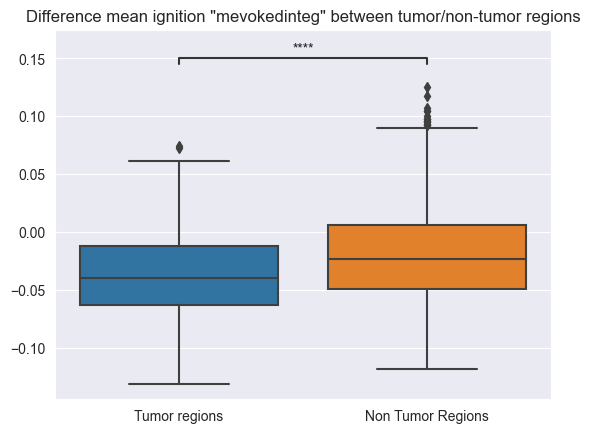

In [11]:

# We compute the mean ignition for each region for control subjects
control_mean_ignition = np.zeros(68)
for k, sub in control_subset.items():
    for i in range(68):
        control_mean_ignition[i] += ignitions[k].mevokedinteg[i]
for i in range(68):
    control_mean_ignition[i] /= control_subset.count()

# Now we compute the difference between patients and control for each region
# and catalog if it is a tumor region or not
tumor_region_diff = []
non_tumor_region_diff = []
for k, s in tumor_subset.items():
    for i in range(68):
        if s.tumor_regions.is_tumor_region_by_id(i):
            tumor_region_diff.append(ignitions[k].mevokedinteg[i] - control_mean_ignition[i])
        else:
            non_tumor_region_diff.append(ignitions[k].mevokedinteg[i] - control_mean_ignition[i])

plotComparisonAcrossLabels2(
    {
        'Tumor regions': tumor_region_diff,
        'Non Tumor Regions': non_tumor_region_diff,
    },
    graphLabel='Difference mean ignition "mevokedinteg" between tumor/non-tumor regions'
)